## U-Net on MxNet

https://github.com/bckenstler/unet-nerve-segmentation-mxnet/blob/master/U-Net%20MXNet.ipynb

Load all modules we need:
- os for file operations
- numpy for matrix operations
- cv2 for image operations
- mxnet for unet implementation
- pyplot for image printing

In [1]:
import os
import numpy as np
import cv2
import mxnet as mx
from mxnet import ndarray as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.utils import resample, shuffle

In [3]:
plt.rcParams['figure.figsize'] = (8.0, 8.0)

Load labels and try to reestablish contours of objects by it

In [4]:
map_ = cv2.imread(r'data/height_maps/frankfurt_000000_013382.png')

Make 2 height maps from 1 row in .png. Maps will be scaled from 0 to 255

In [134]:
flatten_len = 96*96
map1 = map_[:,:flatten_len,0].reshape(96,96)
map2 = map_[:,flatten_len:,0].reshape(96,96)

Zero point (==128) corresponds to boundary, so union of vertical and horizontal will give us overall boundary

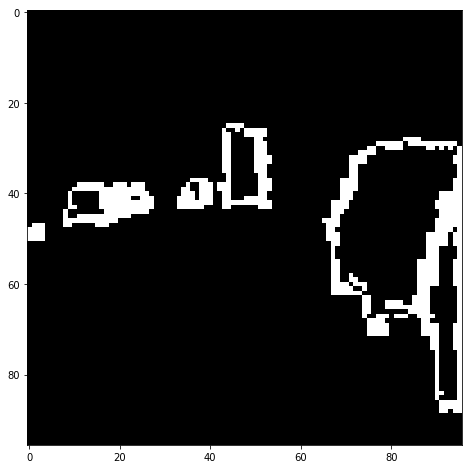

In [6]:
plt.imshow(cv2.bitwise_or((map1==128).astype(np.uint8),(map2==128).astype(np.uint8)), cmap='gray')

RGB version is:

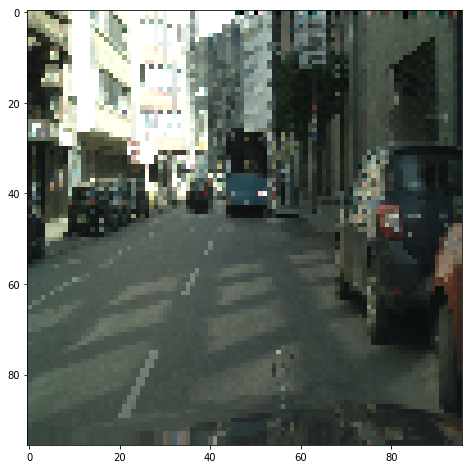

In [129]:
img = cv2.imread(r'data/processed_rgbs/frankfurt_000000_013382_leftImg8bit.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In some cases this "strange" mask works just fine to segment image

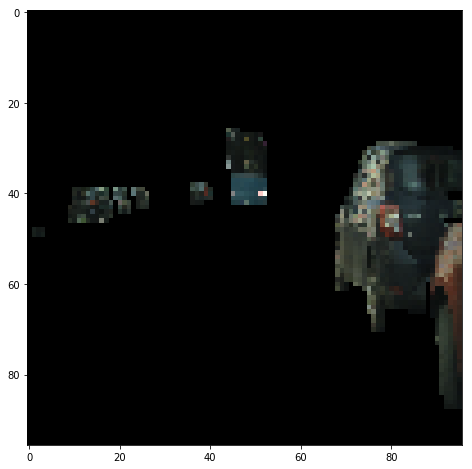

In [136]:
strange_mask = cv2.bitwise_or((map1==0).astype(np.uint8),(map2==0).astype(np.uint8))
_,strange_mask = cv2.threshold(strange_mask,0,255,cv2.THRESH_BINARY_INV)
out = cv2.bitwise_and(img,img,mask = strange_mask)
out = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
plt.imshow(out)

Let's load data in format:
- numpy matrix for each image (h,w,3) in list - X
- numpy matrix for each flatten heights map (1, 96 x 96 x 2) in list - Y

In [9]:
def load_data():
    y_path = r'data\height_maps'
    x_path = r'data\processed_rgbs'
    X = []
    Y = []
    for path, subdirs, files in os.walk(y_path):
        for name in files:
            if name.endswith('.png'):
                map_path = os.path.join(path, name)
                map_data = cv2.imread(map_path)[0,:,0]
                Y.append(map_data)
                rbg_path = map_path.replace(r'\height_maps' , r'\processed_rgbs').replace('.png' , '_leftImg8bit.png')
                rbg = cv2.imread(rbg_path)
                X.append(rbg)
    return X, Y

Shuffle it randomly and partition it into 3 groups - train (to fit model on it), val (to validate model on it) and test (for the  final assessment)

In [10]:
def split_data(X, Y, split=(0.8, 0.1, 0.1)):
    length = len(X)
    assert length == len(Y), 'lengths do not match'
    X, Y = shuffle(X, Y)
    train_x, train_y = X[:int(length*split[0])], Y[:int(length*split[0])]
    val_x, val_y = X[int(length*split[0]): int(length*(split[0]+split[1]))], Y[int(length*split[0]): int(length*(split[0]+split[1]))]
    test_x, test_y = X[int(length*(split[0]+split[1])):], Y[int(length*(split[0]+split[1])):]
    train_x = np.array(train_x)
    train_y = np.array(train_y)
    val_x = np.array(val_x)
    val_y = np.array(val_y)
    test_x = np.array(test_x)
    test_y = np.array(test_y)
    return train_x, train_y, val_x, val_y, test_x, test_y

In [11]:
train_x, train_y, val_x, val_y, test_x, test_y = split_data(*load_data())

In [12]:
print(train_x.shape, val_x.shape)

(213, 96, 96, 3) (27, 96, 96, 3)


Before training input data should be standatized by subtraction of mean of training set and division by std of training set. Moreover we'll need it later for postprocessing, to recover images

In [13]:
mu_train = np.mean(train_x)
std_train = np.std(train_x)

In [14]:
def preprocess_x(array, mu, std):
    array = np.transpose(array, axes=[0,3,1,2]).astype('float32')
    array -= mu
    array /= std
    return array

In [15]:
train_x = preprocess_x(train_x, mu_train, std_train)
val_x = preprocess_x(val_x, mu_train, std_train)
test_x = preprocess_x(test_x, mu_train, std_train)

Y is mapped from 0 to 255 since we packed it into .png. We'll map it from 0 to 1

In [16]:
def preprocess_y(array):
    return array / 255.

In [17]:
train_y = preprocess_y(train_y)
val_y = preprocess_y(val_y)
test_y = preprocess_y(test_y)

Inverse operation to the preprocessing

In [18]:
def postprocess_x(array, mu, std):
    return np.transpose(array.copy() * std + mu, axes=[0,2,3,1]).astype(np.uint8)

In [19]:
val_x.shape

(27, 3, 96, 96)

In [20]:
recover_image = postprocess_x(val_x, mu_train, std_train)[0]

Make sure everything works

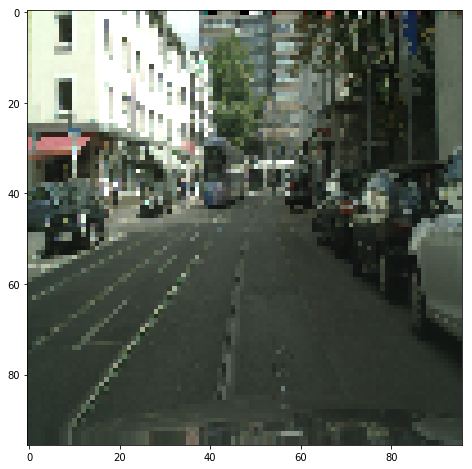

In [21]:
plt.imshow(cv2.cvtColor(recover_image,cv2.COLOR_BGR2RGB))

In [22]:
val_y.shape

(27, 18432)

Get original images as it was in the first part of the homework

In [88]:
def postprocess_y(array):
    map_ = (array.copy() * 96 - 48).astype(np.int)
    flatten_len = 96*96
    size = map_.shape[0]
    map1 = map_[:,:flatten_len].reshape(size,96,96)
    map2 = map_[:,flatten_len:].reshape(size,96,96)
    return map1, map2, cv2.bitwise_or((map1==0).astype(np.uint8),(map2==0).astype(np.uint8))

In [90]:
map1, map2, mask = postprocess_y(val_y)

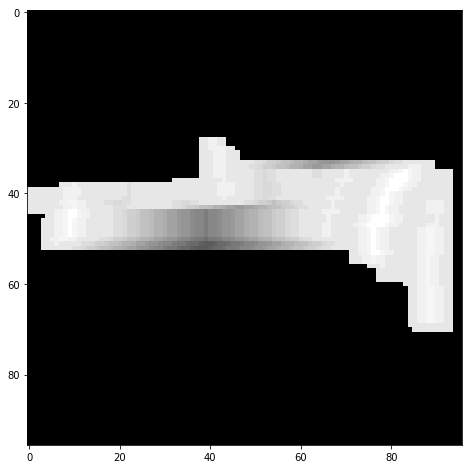

In [93]:
plt.imshow(map2[0],cmap='gray')

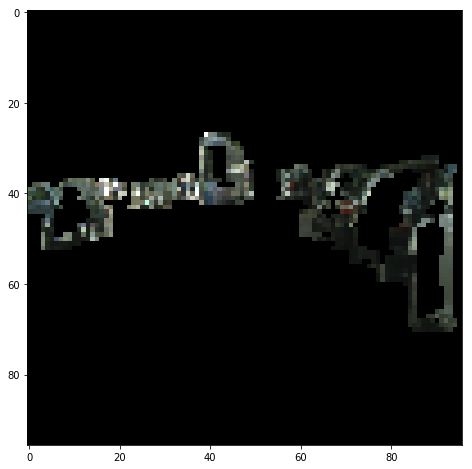

In [111]:
_,stange_mask = cv2.threshold(mask[0],0,255,cv2.THRESH_BINARY)
out = cv2.bitwise_and(recover_image,recover_image,mask = stange_mask)
out = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
plt.imshow(out)

Let's define training shape. It is better to use batch size as power of 2. Since for demostration the small dataset was chosen, 32 is bigger than validation set. Meanwhile my GPU allows to use non-bigger than 8 size of batches

In [26]:
batch_size = 8
data_shape = (batch_size, 3, 96, 96)

Make to data-iterators

In [28]:
train_iter = mx.io.NDArrayIter(data = train_x, label=train_y, batch_size=batch_size, label_name='label', shuffle=True)

val_iter = mx.io.NDArrayIter(data = val_x, label=val_y, batch_size=batch_size, label_name='label', shuffle=False)

U-Net architecture taken from git repo, from keras implemetation, from u-net paper. Number of filters in the least convolution was altered, beacuse our output is twice as big as in the original usage. In order to solve regression problem, MSE loss was chosen

In [29]:
def build_unet():
    data = mx.sym.Variable(name='data')
    label = mx.sym.Variable(name='label')
    conv1 = mx.sym.Convolution(data, num_filter=32, kernel=(3,3), pad=(1,1), name='conv1_1')
    conv1 = mx.sym.BatchNorm(conv1, name='bn1_1')
    conv1 = mx.sym.Activation(conv1, act_type='relu', name='relu1_1')
    conv1 = mx.sym.Convolution(conv1, num_filter=32, kernel=(3,3), pad=(1,1), name='conv1_2')
    conv1 = mx.sym.BatchNorm(conv1, name='bn1_2')
    conv1 = mx.sym.Activation(conv1, act_type='relu', name='relu1_2')
    pool1 = mx.sym.Pooling(conv1, kernel=(2,2), pool_type='max', name='pool1')
    
    conv2 = mx.sym.Convolution(pool1, num_filter=64, kernel=(3,3), pad=(1,1), name='conv2_1')
    conv2 = mx.sym.BatchNorm(conv2, name='bn2_1')
    conv2 = mx.sym.Activation(conv2, act_type='relu', name='relu2_1')
    conv2 = mx.sym.Convolution(conv2, num_filter=64, kernel=(3,3), pad=(1,1), name='conv2_2')
    conv2 = mx.sym.BatchNorm(conv2, name='bn2_2')
    conv2 = mx.sym.Activation(conv2, act_type='relu', name='relu2_2')
    pool2 = mx.sym.Pooling(conv2, kernel=(2,2), pool_type='max', name='pool2')
    
    conv3 = mx.sym.Convolution(pool2, num_filter=128, kernel=(3,3), pad=(1,1), name='conv3_1')
    conv3 = mx.sym.BatchNorm(conv3, name='bn3_1')
    conv3 = mx.sym.Activation(conv3, act_type='relu', name='relu3_1')
    conv3 = mx.sym.Convolution(conv3, num_filter=128, kernel=(3,3), pad=(1,1), name='conv3_2')
    conv3 = mx.sym.BatchNorm(conv3, name='bn3_2')
    conv3 = mx.sym.Activation(conv3, act_type='relu', name='relu3_2')
    pool3 = mx.sym.Pooling(conv3, kernel=(2,2), pool_type='max', name='pool3')
    
    conv4 = mx.sym.Convolution(pool3, num_filter=256, kernel=(3,3), pad=(1,1), name='conv4_1')
    conv4 = mx.sym.BatchNorm(conv4, name='bn4_1')
    conv4 = mx.sym.Activation(conv4, act_type='relu', name='relu4_1')
    conv4 = mx.sym.Convolution(conv4, num_filter=256, kernel=(3,3), pad=(1,1), name='conv4_2')
    conv4 = mx.sym.BatchNorm(conv4, name='bn4_2')
    conv4 = mx.sym.Activation(conv4, act_type='relu', name='relu4_2')
    pool4 = mx.sym.Pooling(conv4, kernel=(2,2), pool_type='max', name='pool4')
    
    conv5 = mx.sym.Convolution(pool4, num_filter=512, kernel=(3,3), pad=(1,1), name='conv5_1')
    conv5 = mx.sym.BatchNorm(conv5, name='bn5_1')
    conv5 = mx.sym.Activation(conv5, act_type='relu', name='relu5_1')
    conv5 = mx.sym.Convolution(conv5, num_filter=512, kernel=(3,3), pad=(1,1), name='conv5_2')
    conv5 = mx.sym.BatchNorm(conv5, name='bn5_2')
    conv5 = mx.sym.Activation(conv5, act_type='relu', name='relu5_2')
    
    trans_conv6 = mx.sym.Deconvolution(conv5, num_filter=256, kernel=(2,2), stride=(1,1), no_bias=True, name='trans_conv6')
    up6 = mx.sym.concat(*[trans_conv6, conv4], dim=1, name='concat6')
    conv6 = mx.sym.Convolution(up6, num_filter=256, kernel=(3,3), pad=(1,1), name='conv6_1')
    conv6 = mx.sym.BatchNorm(conv6, name='bn6_1')
    conv6 = mx.sym.Activation(conv6, act_type='relu', name='relu6_1')
    conv6 = mx.sym.Convolution(conv6, num_filter=256, kernel=(3,3), pad=(1,1), name='conv6_2')
    conv6 = mx.sym.BatchNorm(conv6, name='bn6_2')
    conv6 = mx.sym.Activation(conv6, act_type='relu', name='relu6_2')
    
    trans_conv7 = mx.sym.Deconvolution(conv6, num_filter=128, kernel=(2,2), stride=(1,1), no_bias=True, name='trans_conv7')
    up7 = mx.sym.concat(*[trans_conv7, conv3], dim=1, name='concat7')
    conv7 = mx.sym.Convolution(up7, num_filter=128, kernel=(3,3), pad=(1,1), name='conv7_1')
    conv7 = mx.sym.BatchNorm(conv7, name='bn7_1')
    conv7 = mx.sym.Activation(conv7, act_type='relu', name='relu7_1')
    conv7 = mx.sym.Convolution(conv7, num_filter=128, kernel=(3,3), pad=(1,1), name='conv7_2')
    conv7 = mx.sym.BatchNorm(conv7, name='bn7_2')
    conv7 = mx.sym.Activation(conv7, act_type='relu', name='relu7_2')
    
    trans_conv8 = mx.sym.Deconvolution(conv7, num_filter=64, kernel=(2,2), stride=(1,1), no_bias=True, name='trans_conv8')
    up8 = mx.sym.concat(*[trans_conv8, conv2], dim=1, name='concat8')
    conv8 = mx.sym.Convolution(up8, num_filter=64, kernel=(3,3), pad=(1,1), name='conv8_1')
    conv8 = mx.sym.BatchNorm(conv8, name='bn8_1')
    conv8 = mx.sym.Activation(conv8, act_type='relu', name='relu8_1')
    conv8 = mx.sym.Convolution(conv8, num_filter=64, kernel=(3,3), pad=(1,1), name='conv8_2')
    conv8 = mx.sym.BatchNorm(conv8, name='bn8_2')
    conv8 = mx.sym.Activation(conv8, act_type='relu', name='relu8_2')
    
    trans_conv9 = mx.sym.Deconvolution(conv8, num_filter=32, kernel=(2,2), stride=(1,1), no_bias=True, name='trans_conv9')
    up9 = mx.sym.concat(*[trans_conv9, conv1], dim=1, name='concat9')
    conv9 = mx.sym.Convolution(up9, num_filter=32, kernel=(3,3), pad=(1,1), name='conv9_1')
    conv9 = mx.sym.BatchNorm(conv9, name='bn9_1')
    conv9 = mx.sym.Activation(conv9, act_type='relu', name='relu9_1')
    conv9 = mx.sym.Convolution(conv9, num_filter=32, kernel=(3,3), pad=(1,1), name='conv9_2')
    conv9 = mx.sym.BatchNorm(conv9, name='bn9_2')
    conv9 = mx.sym.Activation(conv9, act_type='relu', name='relu9_2')
    
    conv10 = mx.sym.Convolution(conv9, num_filter=2, kernel=(1,1), name='conv10_1')
    conv10 = mx.sym.sigmoid(conv10, name='sigm10_1')
    
    net = mx.sym.Flatten(conv10)
    
#     net = mx.sym.FullyConnected(data=net, num_hidden=96*96*2, name='fc11_1')
#     net = mx.sym.sigmoid(net, name='sigm11_1')
    
    loss = mx.sym.LinearRegressionOutput(data=net, label=label)
    mask_output = mx.sym.BlockGrad(net, 'mask')
    out = mx.sym.Group([loss, mask_output])
#     return mx.sym.LogisticRegressionOutput(net, name='softmax')
    return out

In [30]:
unet_sym = build_unet()
unet = mx.mod.Module(unet_sym, context=mx.gpu(),data_names=('data',), label_names=('label',))
unet.bind(data_shapes=[['data', data_shape]], label_shapes=[['label', (batch_size, 96*96*2)]])
unet.init_params(mx.initializer.Xavier(magnitude=6))

unet.init_optimizer(optimizer = 'adam', 
                               optimizer_params=(
                                   ('learning_rate', 1E-4),
                                   ('beta1', 0.9),
                                   ('beta2', 0.99)
                              ))

Small vizualization to double check all the dims

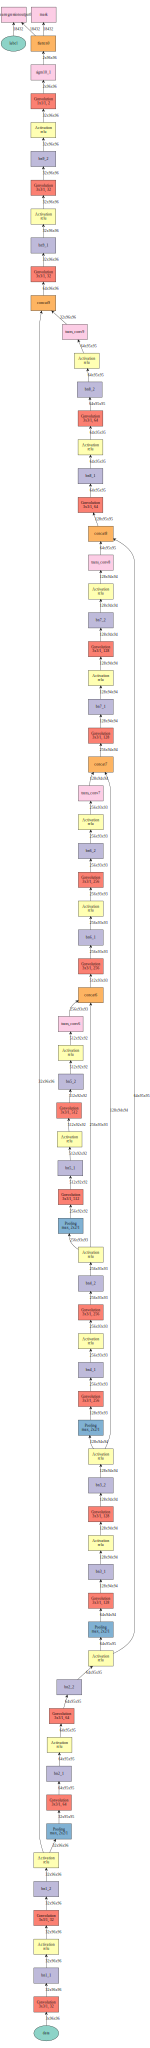

In [31]:
mx.viz.plot_network(unet_sym, shape={"data":data_shape, "label":(batch_size,96*96*2)})

In [32]:
import logging
logging.getLogger().setLevel(logging.DEBUG)

In [113]:
epochs = 20
smoothing_constant = .01
curr_losses = []
moving_losses = []
i = 0
best_val_loss = np.inf
for e in range(epochs):
    while True:
        try:
            batch = next(train_iter)
        except StopIteration:
            train_iter.reset()
            break
        unet.forward_backward(batch)
        loss = unet.get_outputs()[0]
        unet.update()
        curr_loss = F.mean(loss).asscalar()
        curr_losses.append(curr_loss)
        moving_loss = (curr_loss if ((i == 0) and (e == 0))
                               else (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss)
        moving_losses.append(moving_loss)
        i += 1
    val_losses = []
    for batch in val_iter:
        unet.forward(batch)
        loss = unet.get_outputs()[0]
        val_losses.append(F.mean(loss).asscalar())
    val_iter.reset()
    val_loss = np.mean(val_losses)
    if e > 20 and val_loss < best_val_loss:
        best_val_loss = val_loss
        unet.save_checkpoint('best_unet', 0)
        print("Best model at Epoch %i" %(e+1))
    print("Epoch %i: Moving Training Loss %0.5f, Validation Loss %0.5f" % (e+1, moving_loss, val_loss))

Epoch 1: Moving Training Loss 0.28247, Validation Loss 0.28071
Epoch 2: Moving Training Loss 0.28095, Validation Loss 0.27292
Epoch 3: Moving Training Loss 0.27834, Validation Loss 0.26763
Epoch 4: Moving Training Loss 0.27503, Validation Loss 0.26299
Epoch 5: Moving Training Loss 0.27128, Validation Loss 0.25776
Epoch 6: Moving Training Loss 0.26740, Validation Loss 0.25321
Epoch 7: Moving Training Loss 0.26326, Validation Loss 0.24879
Epoch 8: Moving Training Loss 0.25905, Validation Loss 0.24364
Epoch 9: Moving Training Loss 0.25483, Validation Loss 0.23897
Epoch 10: Moving Training Loss 0.25073, Validation Loss 0.23659
Epoch 11: Moving Training Loss 0.24674, Validation Loss 0.23168
Epoch 12: Moving Training Loss 0.24270, Validation Loss 0.22791
Epoch 13: Moving Training Loss 0.23872, Validation Loss 0.22466
Epoch 14: Moving Training Loss 0.23473, Validation Loss 0.22114
Epoch 15: Moving Training Loss 0.23083, Validation Loss 0.21733
Epoch 16: Moving Training Loss 0.22702, Validatio

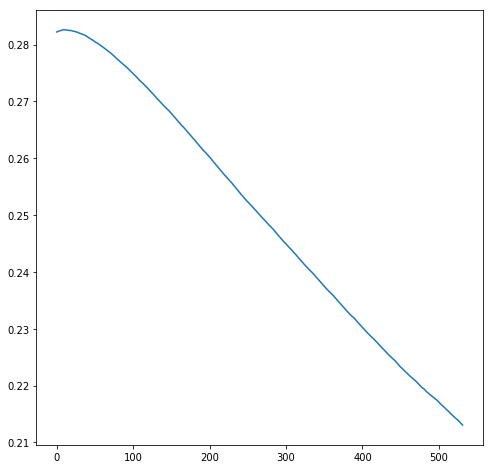

In [114]:
plt.plot(moving_losses)

After tha training let's see what we get. Firstly, look at an arbitrary validation example, it's height map and boundaries

In [115]:
batch = next(val_iter)

unet.forward(batch)

outputs = unet.get_outputs()[1]

In [116]:
ximages = postprocess_x(batch.data[0].asnumpy(), mu_train, std_train)

In [117]:
ymaps1, ymaps2, ymasks = postprocess_y(batch.label[0].asnumpy())

In [119]:
lmaps1, lmaps2, lmasks = postprocess_y(outputs.asnumpy())

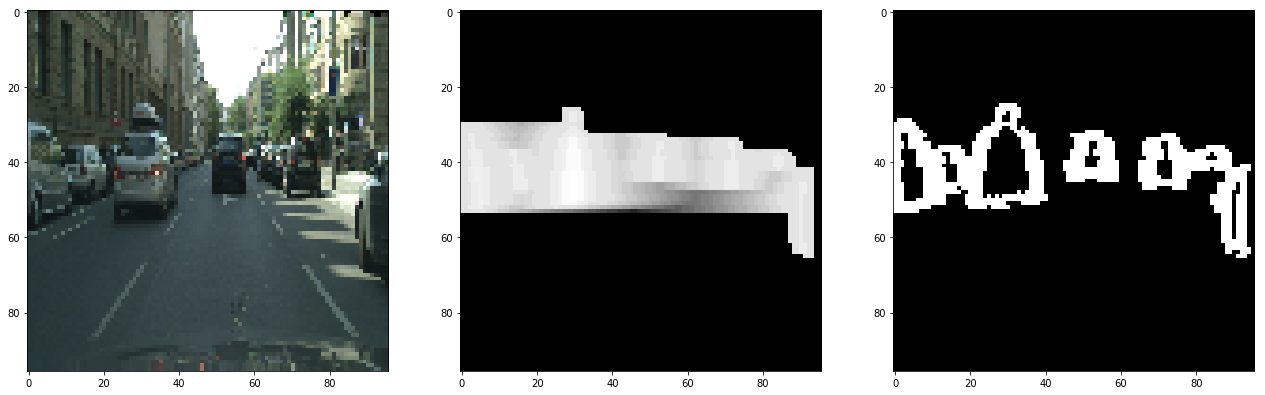

In [125]:
index = 2

ximage = ximages[index]
ximage = cv2.cvtColor(ximage,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(22, 22))
plt.subplot(131)
plt.imshow(ximage)

ymask = ymaps2[index]
plt.subplot(132)
plt.imshow(ymask, cmap=plt.cm.gray)

ymask = ymasks[index]
plt.subplot(133)
plt.imshow(ymask, cmap=plt.cm.gray)

Then, let's look at the network's output. Model has been training just a few epochs, on the little dataset, nonetheless it has ended in something reasonable.

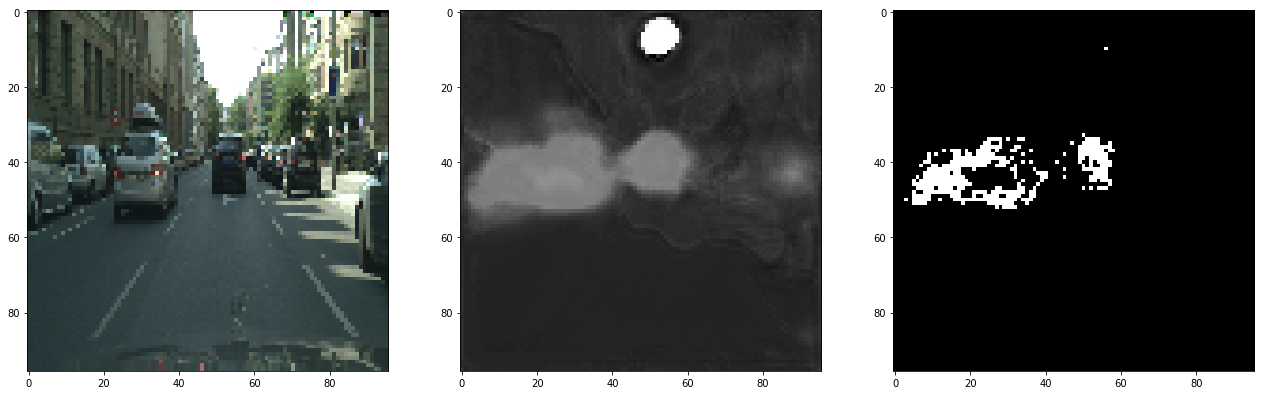

In [128]:
plt.figure(figsize=(22, 22))
plt.subplot(131)
plt.imshow(ximage)

lmask = lmaps2[index]
plt.subplot(132)
plt.imshow(lmask, cmap=plt.cm.gray)

lmask = lmasks[index]
plt.subplot(133)
plt.imshow(lmask, cmap=plt.cm.gray)